# Clustering (Users)
The purpose of this notebook is to cluster the top 10k Netflix users, represented by their preference ratios across the 400 top engineered features.

We find that the movie feature preferences of the top 10k users follow an elliptical Gaussian distribution for the first 2 principle components, resulting in no valid cluster separation.<br>
These results are in stark contrast with the movie feature clusters which have surprisingly well-separated hierarchical cluster groups.

- Aidan Quinn and Alec Guiness are the most highly rated features for a large portion of the user base
- Performing DBSCAN on a 2D PCA projection of the dataset and performing a very conservative DBSCAN clustering, we find two outlier: 
    1. A user with Anthony Quinn and Donald Pleasence as their two most highly rated features: 60's action fan who loves the Halloween movie series
    2. A user who, despite rating over 800 movies, has not rated a single movie with our engineered features of interest

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pickle
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px

DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
IMDB_FOLDER_PATH = os.path.join(DATA_PATH, "imdb")
MIN_OCCURRENCES = 20
USER_PROFILE_PATH = os.path.join(DATA_PATH, f"processed/user_profiles_{MIN_OCCURRENCES}.pickle")

##  Load User Profiles

In [2]:
with open(USER_PROFILE_PATH, "rb") as f: user_profiles = pickle.load(f)

# Convert user profiles to DataFrame
user_features = []
user_ids = []

for user_id, profile in user_profiles.items():
    user_ids.append(user_id)
    user_features.append([profile["feature_preferences"].get(fid, -1) for fid in range(len(profile["feature_preferences"]))])

user_features_df = pd.DataFrame(user_features, index=user_ids)

In [3]:
# Drop runtime features 435, 436 437, 438
user_features_df = user_features_df.drop(columns=[435, 436, 437, 438])

In [63]:
id_to_feature = pd.read_pickle(os.path.join(DATA_PATH, "processed", "feature_mapping_20.pickle"))['id_to_feature']

def get_top_features(user_id):
    preferences = user_profiles[user_id]["feature_preferences"]
    top = sorted(preferences.items(), key=lambda x: x[1], reverse=True)
    # features = [f"Feature {fid}" for fid, score in top[:10] if score > 0]
    features = [id_to_feature[fid] for fid, score in top[:10] if score > 0]
    return ", ".join(features) if features else "No Preferences"

## Visualize Users in 2D

In [ ]:
# Apply PCA to reduce to 2 dimensions - using raw data with -1 values intact
pca = PCA(n_components=2)
user_features_2d = pca.fit_transform(user_features_df)

# Create DataFrame for plotting
plot_df = pd.DataFrame(
    user_features_2d,
    columns=['PC1', 'PC2'],
    index=user_ids
)

# Calculate explained variance ratio for axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# Create interactive scatter plot with plotly
fig = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    opacity=0.6,
    title='User Feature Preferences - 2D PCA Visualization (Raw Data)',
    labels={
        'PC1': f'PC1 ({explained_variance[0]:.1f}% variance explained)',
        'PC2': f'PC2 ({explained_variance[1]:.1f}% variance explained)'
    }
)

# Update layout for better visibility
fig.update_layout(
    plot_bgcolor='white',
    width=900,
    height=600
)

# Add grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

# Print variance explained
print(f"Total variance explained by 2 components: {sum(explained_variance):.1f}%")

## K-Means Clustering

### Plot Metrics Across Values of k

In [ ]:
def compute_clustering_metrics(data, k_range):
    silhouette_scores = []
    ch_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
        ch_scores.append(calinski_harabasz_score(data, labels))
    
    return silhouette_scores, ch_scores

# Compute metrics across values of k
k_range = range(2, 21)
silhouette_scores, ch_scores = compute_clustering_metrics(user_features_df, k_range)

# Plot metrics
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(k_range, silhouette_scores, label="Silhouette Score", marker="o")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Clustering Metrics for K-Means")
ax1.legend(loc="best")

ax2 = ax1.twinx()
ax2.plot(k_range, ch_scores, label="Calinski-Harabasz Index", marker="s", color="orange")
ax2.set_ylabel("Calinski-Harabasz Index")
ax2.legend(loc="best")

plt.tight_layout()
plt.show()

### Visualize Clusters for Best k (k=2)

In [ ]:
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Selected number of clusters (k): {best_k}")

# Perform K-Means clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(user_features_df)

# Add cluster labels to DataFrame
user_features_df["cluster"] = labels

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(user_features_df.drop("cluster", axis=1))
reduced_features_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"], index=user_features_df.index)
reduced_features_df["cluster"] = labels

# Add top 3 feature preferences to tooltip
def top_3_features(user_id):
    preferences = user_profiles[user_id]["feature_preferences"]
    sorted_prefs = sorted(preferences.items(), key=lambda x: x[1], reverse=True)
    top_features = [f"Feature {fid}" for fid, score in sorted_prefs[:10] if score > 0]
    return ", ".join(top_features) if top_features else "No Preferences"

reduced_features_df["tooltip"] = reduced_features_df.index.map(top_3_features)

# Convert cluster labels to strings for discrete colors
reduced_features_df["cluster"] = "Cluster " + reduced_features_df["cluster"].astype(str)


fig = px.scatter(
    reduced_features_df,
    x="PCA1",
    y="PCA2",
    color="cluster",
    color_discrete_sequence=px.colors.qualitative.Set1,
    hover_data={"tooltip": True, "PCA1": False, "PCA2": False},
    title="User Clusters Visualized in 2D (PCA)"
)
fig.update_traces(marker=dict(size=10, opacity=0.7), selector=dict(mode="markers"))
fig.show()

### Reduce to 300D via PCA and Cluster

As we visualize the first 2 principal components, we observe a linearly separable line around the origin. The two clusters are separated at this line.

In [ ]:
# Apply PCA
pca = PCA(n_components=300)
user_features_df.columns = user_features_df.columns.astype(str)
user_features_pca = pca.fit_transform(user_features_df)

# Compute clustering metrics
def compute_clustering_metrics(data, k_range):
    metrics = {'silhouette': [], 'ch': []}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics['silhouette'].append(silhouette_score(data, labels))
        metrics['ch'].append(calinski_harabasz_score(data, labels))
    return metrics

# Find optimal k
k_range = range(2, 21)
metrics = compute_clustering_metrics(user_features_pca, k_range)
best_k = k_range[np.argmax(metrics['silhouette'])]

# Perform final clustering
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(user_features_pca)

# Use first two components from the original PCA
reduced_df = pd.DataFrame(user_features_pca[:, :2], columns=['PCA1', 'PCA2'], index=user_features_df.index)
reduced_df['cluster'] = [f'Cluster {l}' for l in labels]

reduced_df['tooltip'] = reduced_df.index.map(get_top_features)

# Visualize
fig = px.scatter(
    reduced_df,
    x="PCA1",
    y="PCA2",
    color="cluster",
    color_discrete_sequence=px.colors.qualitative.Set1,
    hover_data={"tooltip": True, "PCA1": False, "PCA2": False},
    title=f"User Clusters in 2D (First Two Components of {best_k} Clusters)"
)
fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.show()

print(f"Selected number of clusters (k): {best_k}")
print(f"Explained variance ratio (300D PCA): {pca.explained_variance_ratio_.sum():.3f}")
print(f"Explained variance ratio (first 2 components): {pca.explained_variance_ratio_[:2].sum():.3f}")

# DBSCAN
For DBSCAN, we apply PCA 300D and 2D before clustering. This was purposely done as a way of ensuring that the one true outlier in the dataset (user with no ratings across all of the top features) is flagged as such

### Utils

In [45]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Calculate k-distances to determine a good value for eps
def plot_k_distance(data, k=5):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    # plt.axhline(y=0.5, color='r', linestyle='--', label="Potential Eps")
    plt.title("K-distance Plot (k={})".format(k))
    plt.xlabel("Points sorted by distance to {}-th nearest neighbor".format(k))
    plt.ylabel("{}-th Nearest Neighbor Distance".format(k))
    plt.legend()
    plt.grid()
    plt.show()


def visualize_dbscan_clusters(eps, min_samples, dim=2):
    # Step 2: Perform DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(user_features_pca)

    # Step 3: Identify outliers
    outliers = user_features_df.index[labels == -1]
    print(f"Number of outliers detected: {len(outliers)}")
    print(f"Outlier user IDs: {outliers.tolist()}")

    # Step 4: Visualize results

    # Use the first two PCA components for visualization
    reduced_df = pd.DataFrame(user_features_pca[:, :2], columns=['PCA1', 'PCA2'], index=user_features_df.index)
    reduced_df['cluster'] = labels
    reduced_df['cluster'] = reduced_df['cluster'].replace(-1, 'Outlier')

    # Add tooltips
    reduced_df['tooltip'] = reduced_df.index.map(get_top_features)

    # Plot results
    fig = px.scatter(
        reduced_df,
        x='PCA1',
        y='PCA2',
        color='cluster',
        color_discrete_sequence=px.colors.qualitative.Set1,
        hover_data={'tooltip': True, 'PCA1': False, 'PCA2': False},
        title=f'DBSCAN Clustering Results Using {dim}D Vectors'
    )
    fig.update_traces(marker=dict(size=10, opacity=0.7))
    fig.show()

    # Print a summary
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Number of clusters found (excluding outliers): {num_clusters}")

### Cluster using PCA 300D

/var/folders/kb/fzfpswzs5pvfz2g6vhp6r2dw0000gn/T/ipykernel_73478/3145002361.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



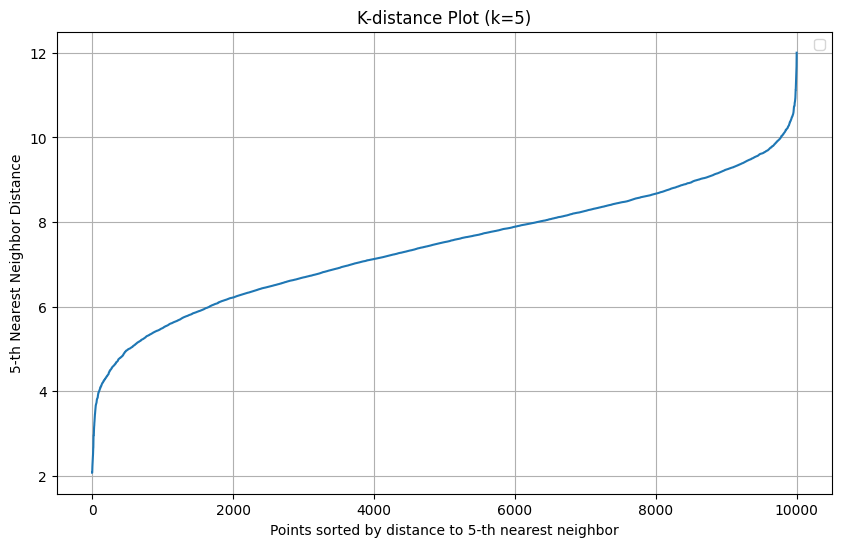

Number of outliers detected: 9840
Outlier user IDs: ['2530071', '2492994', '189887', '1343332', '76444', '232549', '1333129', '2307327', '1756407', '141370', '308990', '2244849', '1065598', '1262713', '768483', '437182', '675410', '1697865', '2332943', '798262', '73988', '1579371', '2509303', '1781102', '1728944', '544925', '1086736', '848753', '923631', '291248', '287545', '1939221', '1269749', '845921', '944944', '1218493', '1872980', '1417705', '640174', '1529376', '2208519', '549094', '273814', '489454', '1831058', '1035650', '842706', '972616', '757456', '1442105', '1233457', '1183823', '458656', '651129', '882429', '867967', '2466211', '608501', '984474', '2145961', '684531', '915898', '801010', '1725567', '270049', '1801528', '1385788', '50075', '758353', '1730558', '416214', '2360244', '1931026', '1539389', '2167041', '1884737', '968184', '903296', '1250006', '2531844', '1704440', '2256731', '152063', '341330', '2245510', '1441540', '1428452', '10638', '385977', '2229666', '246

Number of clusters found (excluding outliers): 3


In [73]:
dim=300
pca = PCA(n_components=dim)
user_features_df.columns = user_features_df.columns.astype(str)
user_features_pca = pca.fit_transform(user_features_df.copy())

plot_k_distance(user_features_pca, k=5)
visualize_dbscan_clusters(4,5,dim=300)

### Cluster using PCA 2D

/var/folders/kb/fzfpswzs5pvfz2g6vhp6r2dw0000gn/T/ipykernel_73478/3145002361.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



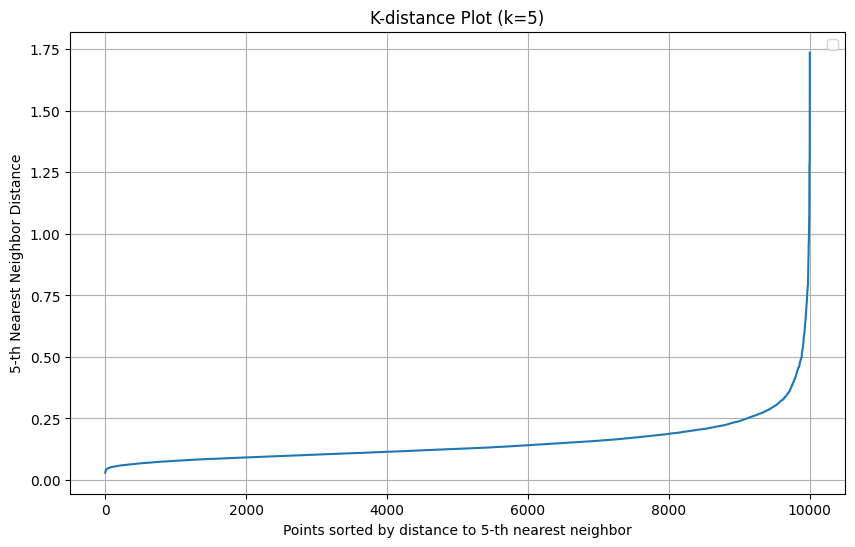

Number of outliers detected: 2
Outlier user IDs: ['2170930', '66540']


Number of clusters found (excluding outliers): 1


In [74]:
dim=2
pca = PCA(n_components=dim)
user_features_df.columns = user_features_df.columns.astype(str)
user_features_pca = pca.fit_transform(user_features_df.copy())

plot_k_distance(user_features_pca, k=5)
visualize_dbscan_clusters(1,5,dim=2)